## **El Niño Analysis Using PySpark for Predicting Sea Surface Temperature**

Annisaa Fitri Nurfirdausi - 0001110915

## **1. PySpark Set Up and Data Inspection**

We initialize a PySpark SparkSession to process data on a Spark cluster running locally, with specified executor memory, driver memory, and cores. The elnino.csv dataset is read, inferring the schema and using the first row as headers. The schema of the dataset is printed, and the first 5 rows are displayed for inspection.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://localhost:7077") \
    .appName("ElNino") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()


df = spark.read.csv('elnino.csv', header=True, inferSchema=True)
df.printSchema()
df.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/08 10:50:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- obs: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- zon.winds: string (nullable = true)
 |-- mer.winds: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- air temp.: string (nullable = true)
 |-- s.s.temp.: string (nullable = true)

+---+----+-----+---+------+--------+---------+---------+---------+--------+---------+---------+
|obs|year|month|day|  date|latitude|longitude|zon.winds|mer.winds|humidity|air temp.|s.s.temp.|
+---+----+-----+---+------+--------+---------+---------+---------+--------+---------+---------+
|  1|  80|    3|  7|800307|   -0.02|  -109.46|     -6.8|      0.7|       .|    26.14|    26.24|
|  2|  80|    3|  8|800308|   -0.02|  -109.46|     -4.9|      1.1|       .|    25.66|    25.97|
|  3|  80|    3|  9|800309|   -0.02|  -109.46

In [2]:
num_rows = df.count()
print(f' there are {num_rows} rows in the dataset')

 there are 178080 rows in the dataset


We rename the columns in the DataFrame to more readable names

In [3]:
new_column_names = {
    'obs': 'observation',
    'year': 'year',
    'month': 'month',
    'day': 'day',
    'date': 'date',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'zon.winds': 'zonal_winds',
    'mer.winds': 'meridional_winds',
    'humidity': 'humidity',
    'air temp.': 'air_temperature',
    's.s.temp.': 'sea_surface_temperature'
}

for old_name, new_name in new_column_names.items():
    df = df.withColumnRenamed(old_name, new_name)

We would like to convert the time variables (year, month, day, date) into a 'date' format to make it easier to perform time-based operations, such as filtering, grouping by date, and plotting over time.

In [4]:
from pyspark.sql.functions import col, concat_ws, to_date, when, lpad

df = df.withColumn("year", when(col("year") < 100, col("year") + 1900).otherwise(col("year")))
df = df.withColumn("month", lpad(col("month"), 2, "0"))
df = df.withColumn("day", lpad(col("day"), 2, "0"))
df = df.withColumn("date", to_date(concat_ws("-", col("year"), col("month"), col("day"))))

df = df.drop("year", "month", "day")

df.show()


+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+
|observation|      date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|
+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+
|          1|1980-03-07|   -0.02|  -109.46|       -6.8|             0.7|       .|          26.14|                  26.24|
|          2|1980-03-08|   -0.02|  -109.46|       -4.9|             1.1|       .|          25.66|                  25.97|
|          3|1980-03-09|   -0.02|  -109.46|       -4.5|             2.2|       .|          25.69|                  25.28|
|          4|1980-03-10|   -0.02|  -109.46|       -3.8|             1.9|       .|          25.57|                  24.31|
|          5|1980-03-11|   -0.02|  -109.46|       -4.2|             1.5|       .|           25.3|                  23.19|
|          6|1980-03-12|

## **2. Feature Engineering**

On this section, we will add some new necessary variables: 
- El Nino (whether the El Nino is occured on that period)
- Ocean (whether it is located in the West Pacific or East Pacific)
- Hemisphere (whether it is located in South or North Hemisphere)

### **2.1. El Nino**

Based on the past records, El Nino happened on these period ranges:
1. Between May 1982 and June 1983 [https://www.nature.com/articles/305016a0.pdf]
2. Between May 1997 and June 1998 [https://en.wikipedia.org/wiki/1997–98_El_Niño_event]

In [5]:
from pyspark.sql import functions as F

# El Nino Period
elnino_period_1_start = F.to_date(F.lit("1982-05-01"), "yyyy-MM-dd")
elnino_period_1_end = F.to_date(F.lit("1983-06-30"), "yyyy-MM-dd")

elnino_period_2_start = F.to_date(F.lit("1997-05-01"), "yyyy-MM-dd")
elnino_period_2_end = F.to_date(F.lit("1998-06-30"), "yyyy-MM-dd")

df = df.withColumn(
    "El Nino",
    F.when(
        (df["date"] >= elnino_period_1_start) & (df["date"] <= elnino_period_1_end) |
        (df["date"] >= elnino_period_2_start) & (df["date"] <= elnino_period_2_end),
        "Yes"
    ).otherwise("No")
)

df.show(5)

+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+
|observation|      date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|
+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+
|          1|1980-03-07|   -0.02|  -109.46|       -6.8|             0.7|       .|          26.14|                  26.24|     No|
|          2|1980-03-08|   -0.02|  -109.46|       -4.9|             1.1|       .|          25.66|                  25.97|     No|
|          3|1980-03-09|   -0.02|  -109.46|       -4.5|             2.2|       .|          25.69|                  25.28|     No|
|          4|1980-03-10|   -0.02|  -109.46|       -3.8|             1.9|       .|          25.57|                  24.31|     No|
|          5|1980-03-11|   -0.02|  -109.46|       -4.2|             1.5|       .|         

### **2.2. Ocean and Hemisphere**


In [6]:
df = df.withColumn(
    'Ocean',
    F.when(
        (F.col('longitude') < -170.0) | (F.col('longitude') > 160.0), 'West Pacific'
    ).when(
        (F.col('longitude') < -70.0) & (F.col('longitude') > -120.0), 'East Pacific'))

df = df.withColumn('Hemisphere', 
                               F.when(df['latitude'] < 0.0, 'South')
                                .otherwise('North'))

df.show(5)

+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|observation|      date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|       Ocean|Hemisphere|
+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|          1|1980-03-07|   -0.02|  -109.46|       -6.8|             0.7|       .|          26.14|                  26.24|     No|East Pacific|     South|
|          2|1980-03-08|   -0.02|  -109.46|       -4.9|             1.1|       .|          25.66|                  25.97|     No|East Pacific|     South|
|          3|1980-03-09|   -0.02|  -109.46|       -4.5|             2.2|       .|          25.69|                  25.28|     No|East Pacific|     South|
|          4|1980-03-10|   -0.02|  -109.46|       -3.8|             1.9|    

In [7]:
west_pacific_south_count = df.filter((F.col('Ocean') == 'West Pacific') & (F.col('Hemisphere') == 'South')).count()
east_pacific_south_count = df.filter((F.col('Ocean') == 'East Pacific') & (F.col('Hemisphere') == 'South')).count()

print(f"Rows in West Pacific South: {west_pacific_south_count}")
print(f"Rows in East Pacific South: {east_pacific_south_count}")

Rows in West Pacific South: 27174
Rows in East Pacific South: 19013


## **3. Data Cleaning**

### **2.1. Missing Values Handling**


The missing values on the dataset was represented with "." symbol.

In [8]:
from pyspark.sql.functions import col, when, count

df = df.select([when(col(c) == ".", None).otherwise(col(c)).alias(c) for c in df.columns])

missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()


+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|observation|date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|Ocean|Hemisphere|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|          0|   0|       0|        0|      25163|           25162|   65761|          18237|                  17007|      0|86713|         0|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+



Previously, we noticed that there are some columns whose values are not numeric type, we need to ensure that all the values are in the type of numeric.

In [9]:
from pyspark.sql.types import FloatType
df = df.withColumn('zonal_winds', F.col('zonal_winds').cast(FloatType())) \
                   .withColumn('meridional_winds', F.col('meridional_winds').cast(FloatType())) \
                   .withColumn('humidity', F.col('humidity').cast(FloatType())) \
                   .withColumn('air_temperature', F.col('air_temperature').cast(FloatType())) \
                   .withColumn('sea_surface_temperature', F.col('sea_surface_temperature').cast(FloatType()))

df.show(5)

+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|observation|      date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|       Ocean|Hemisphere|
+-----------+----------+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+------------+----------+
|          1|1980-03-07|   -0.02|  -109.46|       -6.8|             0.7|    NULL|          26.14|                  26.24|     No|East Pacific|     South|
|          2|1980-03-08|   -0.02|  -109.46|       -4.9|             1.1|    NULL|          25.66|                  25.97|     No|East Pacific|     South|
|          3|1980-03-09|   -0.02|  -109.46|       -4.5|             2.2|    NULL|          25.69|                  25.28|     No|East Pacific|     South|
|          4|1980-03-10|   -0.02|  -109.46|       -3.8|             1.9|    

Back to the missing values, we have a lot of missing values, especially for Humidity (which covers 30% of the whole dataset). If we drop the rows with missing values, we lose 80K (nearly 50% of the data) which leads to we might lose informations.

We will look into the column with the least missing values, which is **air_temperature** and **sea_surface_temperature**. We will fill them with average values.

In [10]:
df_clean = df

mean_air_temp = df_clean.select(F.avg('air_temperature')).collect()[0][0]
mean_sea_temp = df_clean.select(F.avg('sea_surface_temperature')).collect()[0][0]

df_clean= df_clean.fillna({'air_temperature': mean_air_temp, 'sea_surface_temperature': mean_sea_temp})


And for the winds variables: **zonal_winds** and **meridional_winds**, we will use Imputer. Since wind data may follow a cyclic or periodic pattern, we will use Imputer of most_frequent value

In [11]:
from pyspark.sql import functions as F

df_non_null_zonal_winds = df_clean.filter(df['zonal_winds'].isNotNull())
df_non_null_meridional_winds = df_clean.filter(df['meridional_winds'].isNotNull())

mode_zonal_winds = df_non_null_zonal_winds.groupBy('zonal_winds').count().orderBy(F.desc('count')).first()
mode_meridional_winds = df_non_null_meridional_winds.groupBy('meridional_winds').count().orderBy(F.desc('count')).first()

mode_zonal_winds = mode_zonal_winds[0] if mode_zonal_winds else 0.0
mode_meridional_winds = mode_meridional_winds[0] if mode_meridional_winds else 0.0

df_clean = df_clean.fillna({'zonal_winds': mode_zonal_winds, 'meridional_winds': mode_meridional_winds})


In [12]:
missing_values = df_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

missing_values.show()

+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|observation|date|latitude|longitude|zonal_winds|meridional_winds|humidity|air_temperature|sea_surface_temperature|El Nino|Ocean|Hemisphere|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+
|          0|   0|       0|        0|          0|               0|   65761|              0|                      0|      0|86713|         0|
+-----------+----+--------+---------+-----------+----------------+--------+---------------+-----------------------+-------+-----+----------+



It is the Humidity now that is left. According to the dataset the relative humidity values in the tropical Pacific were typically between 70% and 90%. Since the humidity has inverse relationship on the SST and the temperature change has an important impact on humidity [https://www.mdpi.com/2073-4433/13/10/1718], we can't drop the humidity column. We will then try to drop rows with the missing values (65k data).

In [13]:

df_clean = df_clean.filter(col("humidity").isNotNull())
num_rows = df_clean.count()
print(f'There are {num_rows} rows in the dataset after removing rows with null humidity')

There are 112319 rows in the dataset after removing rows with null humidity


## **4. Exploratory Data Analysis**

### **4.1. Data Distribution**

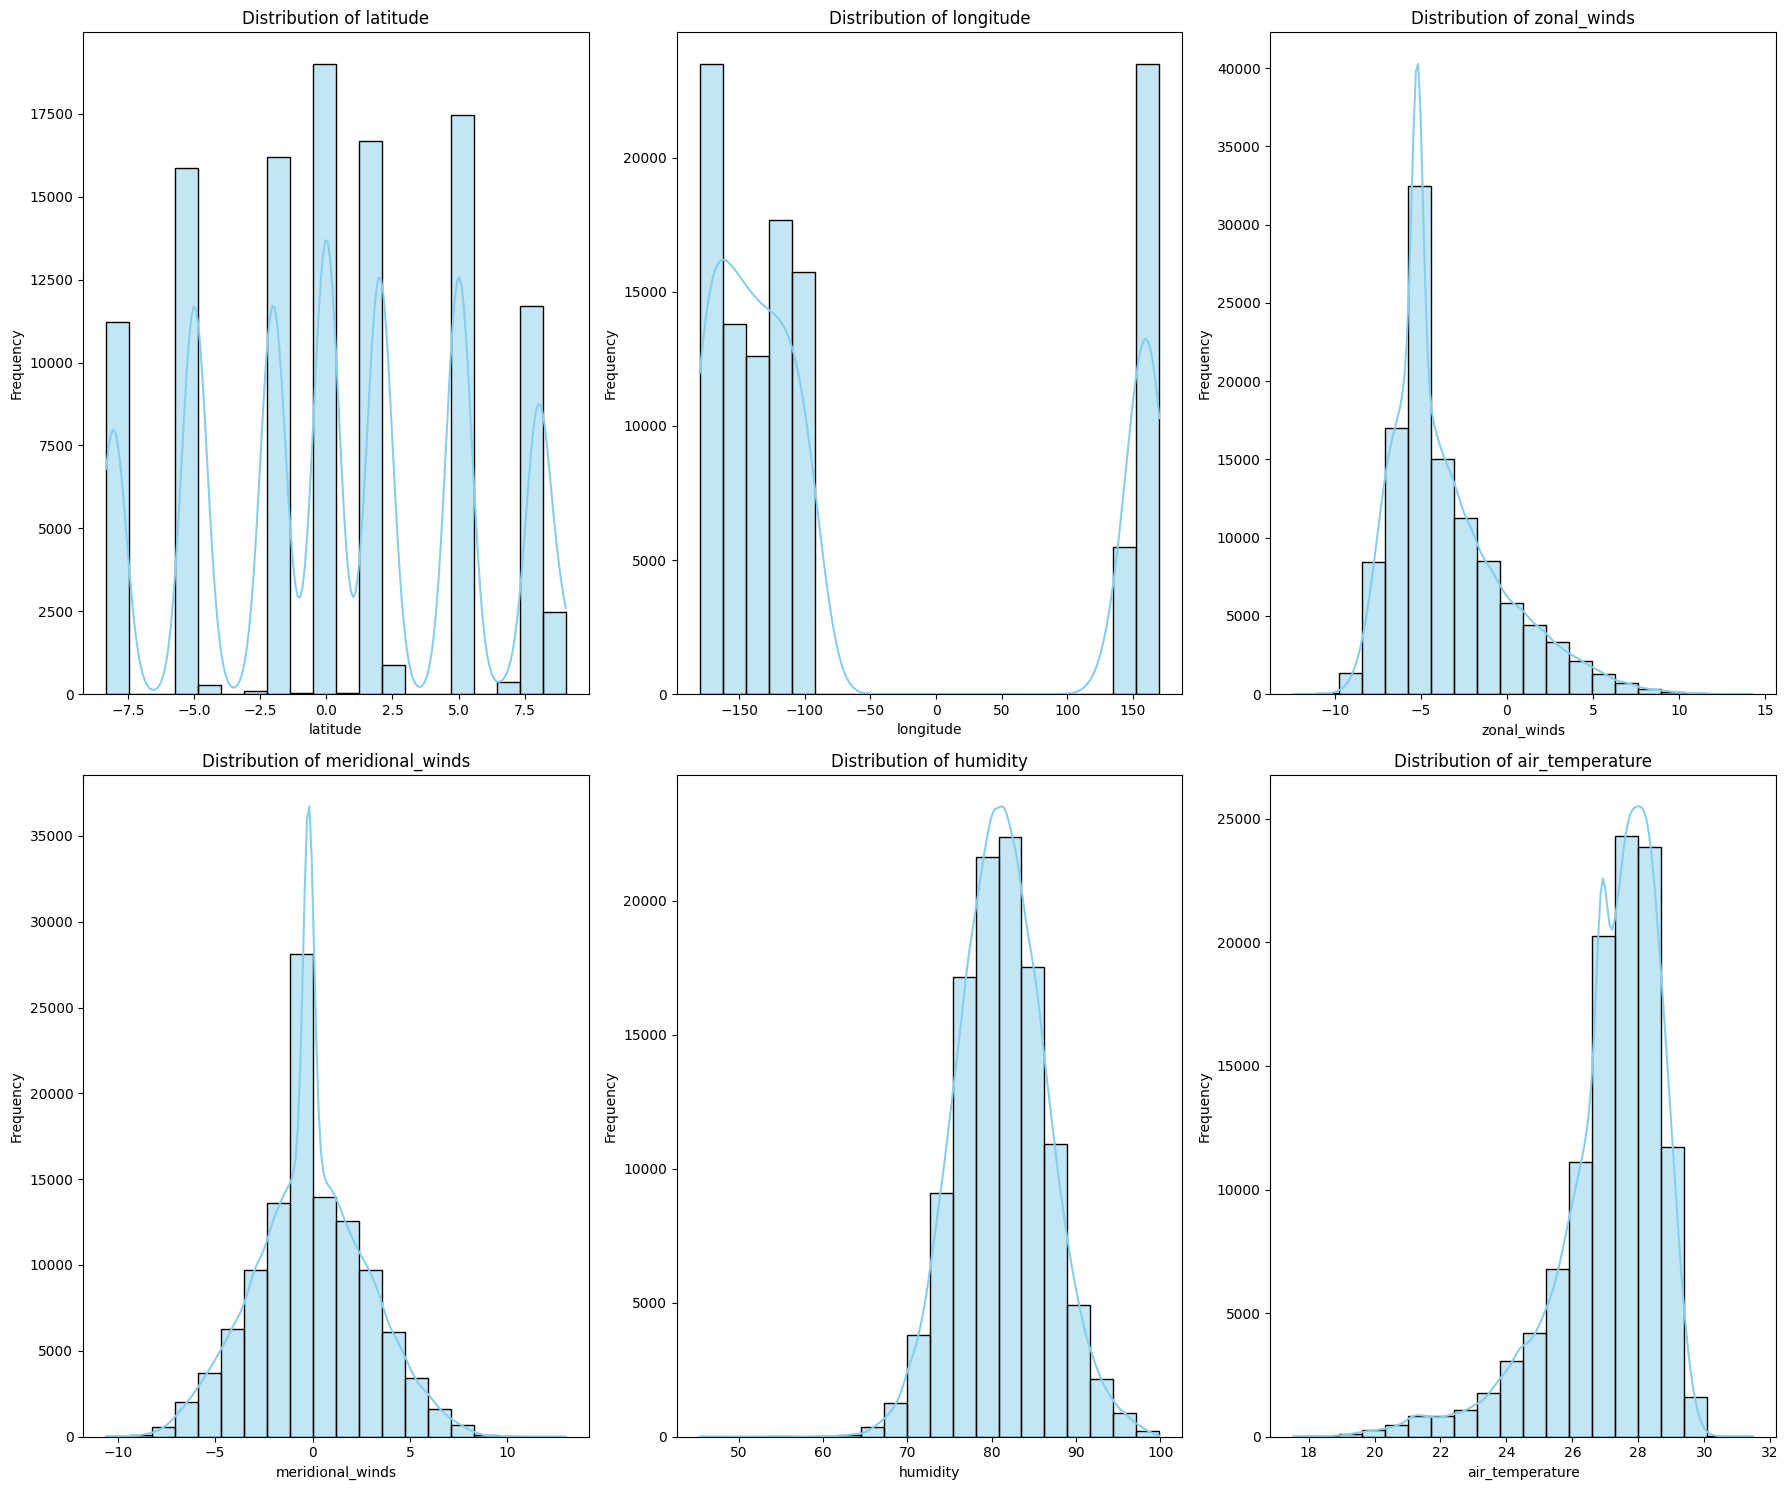

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pandas = df_clean.toPandas()

fig, axes = plt.subplots(2, 3, figsize=(18, 15))
axes = axes.ravel()

columns = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature']

for i, col in enumerate(columns):
    sns.histplot(df_pandas[col], kde=True, ax=axes[i], color='skyblue', bins=20)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### **4.2. Correlation Plot**

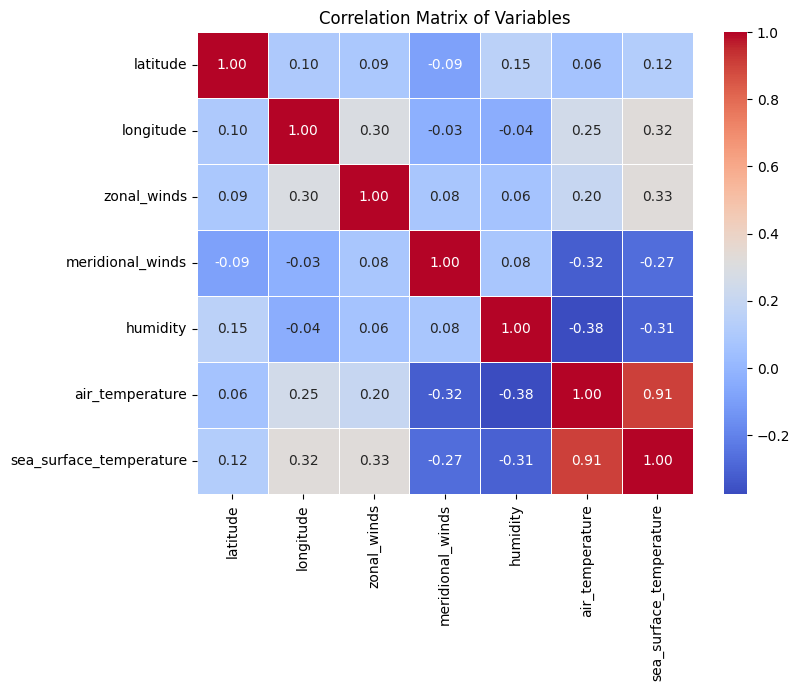

In [15]:
columns = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature', 'sea_surface_temperature']
correlation_matrix = df_pandas[columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.show()

### **4.3. Box Plot**

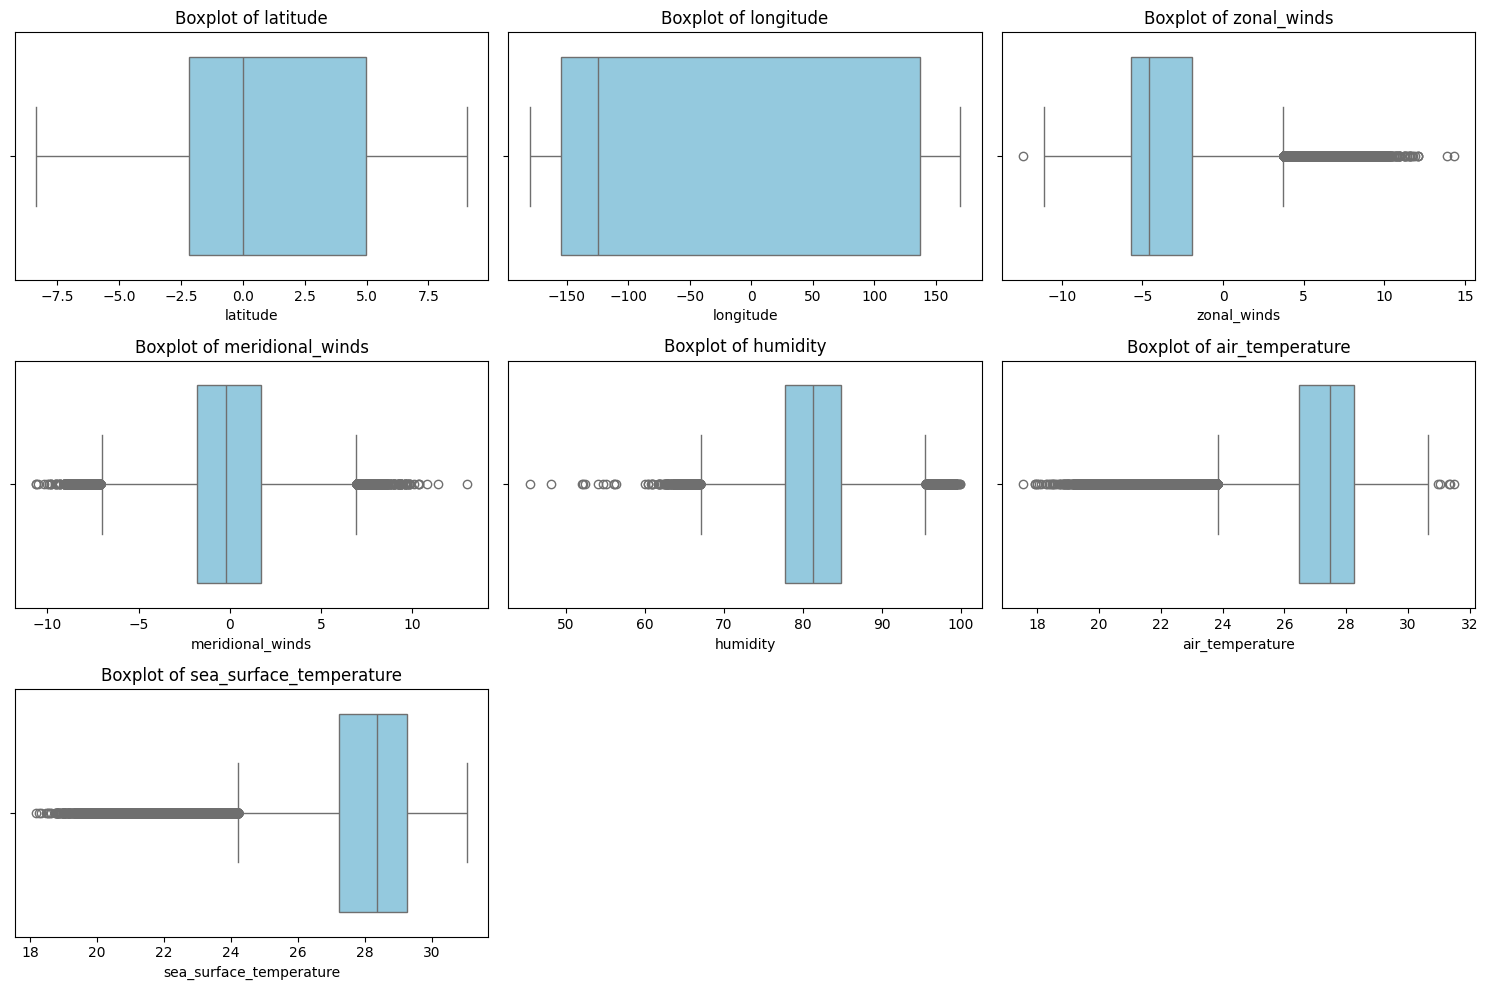

In [16]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))

axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(x=df_pandas[col], color='skyblue', ax=axes[i]) 
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Improve layout
plt.tight_layout()
plt.show()

### **4.4. Distribution of Buoys**

<Axes: title={'center': 'World Distribution of Buoys'}, xlabel='longitude', ylabel='latitude'>

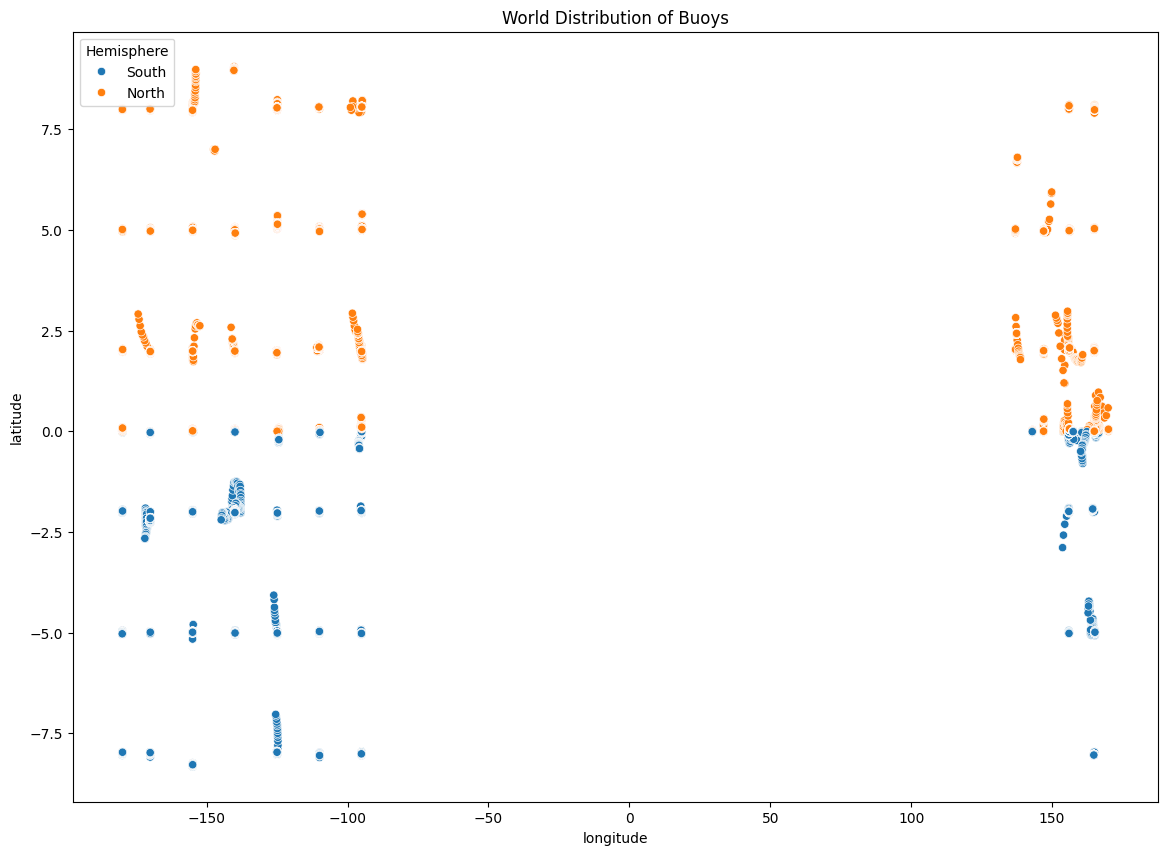

In [17]:
import seaborn as sns

fig = plt.figure(figsize = (14,10))
plt.title('World Distribution of Buoys')
sns.scatterplot(x='longitude',y= 'latitude',data=df_pandas, hue='Hemisphere')

### **4.5. Wind Analysis**

In [18]:
wind_analysis_pd = df_pandas.groupby(['Ocean', 'Hemisphere']).agg(
    Avg_Zonal_Winds=('zonal_winds', 'mean'),
    Avg_Meridional_Winds=('meridional_winds', 'mean')
).reset_index()

print(wind_analysis_pd)


          Ocean Hemisphere  Avg_Zonal_Winds  Avg_Meridional_Winds
0  East Pacific      North        -2.428267              2.087556
1  East Pacific      South        -5.032071              2.224465
2  West Pacific      North        -3.054834             -1.133525
3  West Pacific      South        -2.541788             -0.902180


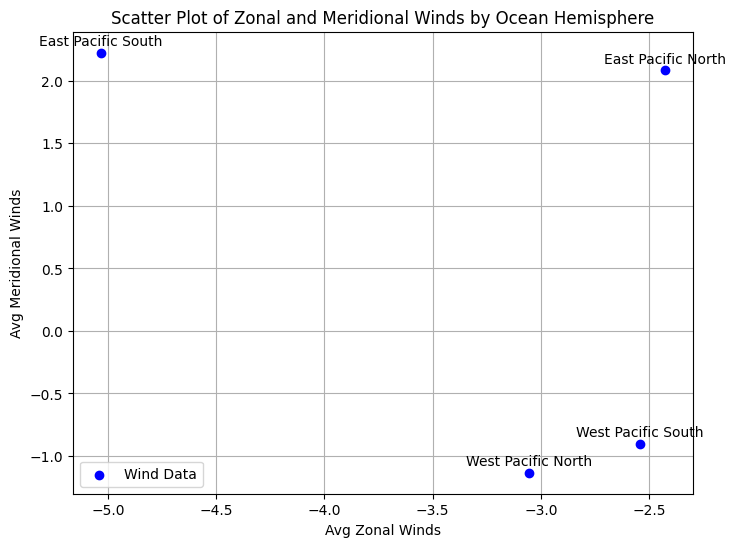

In [19]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(wind_analysis_pd['Avg_Zonal_Winds'], wind_analysis_pd['Avg_Meridional_Winds'], c='blue', label='Wind Data')

# Annotate the points with Ocean and Hemisphere information
for i in range(len(wind_analysis_pd)):
    label = f"{wind_analysis_pd['Ocean'][i]} {wind_analysis_pd['Hemisphere'][i]}"
    plt.annotate(label, 
                 (wind_analysis_pd['Avg_Zonal_Winds'][i], wind_analysis_pd['Avg_Meridional_Winds'][i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

# Labels and title
plt.xlabel('Avg Zonal Winds')
plt.ylabel('Avg Meridional Winds')
plt.title('Scatter Plot of Zonal and Meridional Winds by Ocean Hemisphere')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

We will now compare some of the variables between when the El Nino is occured and when El Nino is not occured. We will make subset of the data first.

In [20]:
east_pacific_no_elnino = df.filter((df['Ocean'] == 'East Pacific') & (df['El Nino'] == 'No'))
east_pacific_yes_elnino = df.filter((df['Ocean'] == 'East Pacific') & (df['El Nino'] == 'Yes'))
west_pacific_no_elnino = df.filter((df['Ocean'] == 'West Pacific') & (df['El Nino'] == 'No'))
west_pacific_yes_elnino = df.filter((df['Ocean'] == 'West Pacific') & (df['El Nino'] == 'Yes'))

### **4.6. Sea Temperature Average**

In [21]:
avg_temp_yes_elnino = west_pacific_yes_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_yes_elnino')).collect()
avg_temp_no_elnino = west_pacific_no_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_no_elnino')).collect()

print(f"Average Sea Surface Temperature in West Pacific (with El Nino): {avg_temp_yes_elnino}")
print(f"Average Sea Surface Temperature in West Pacific (without El Nino): {avg_temp_no_elnino}")

Average Sea Surface Temperature in West Pacific (with El Nino): [Row(avg_temp_yes_elnino=28.9727796310267)]
Average Sea Surface Temperature in West Pacific (without El Nino): [Row(avg_temp_no_elnino=29.122235541836616)]


In [22]:
avg_temp_yes_elnino_east = east_pacific_yes_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_yes_elnino')).collect()
avg_temp_no_elnino_east = east_pacific_no_elnino.agg(F.avg('sea_surface_temperature').alias('avg_temp_no_elnino')).collect()

print(f"Average Sea Surface Temperature in East Pacific (with El Nino): {avg_temp_yes_elnino_east}")
print(f"Average Sea Surface Temperature in East Pacific (without El Nino): {avg_temp_no_elnino_east}")

Average Sea Surface Temperature in East Pacific (with El Nino): [Row(avg_temp_yes_elnino=27.965628147390696)]
Average Sea Surface Temperature in East Pacific (without El Nino): [Row(avg_temp_no_elnino=25.321728356014237)]


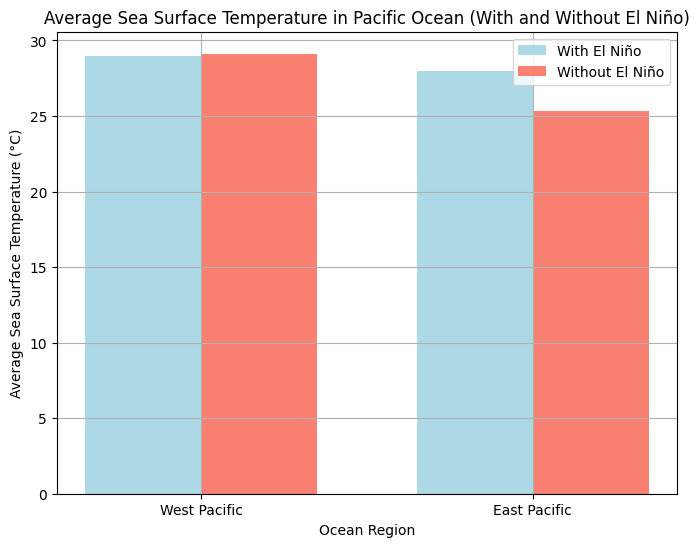

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
oceans = ['West Pacific', 'East Pacific']
temp_with_elnino = [28.9727796310267, 27.965628147390696]
temp_without_elnino = [29.122235541836616, 25.321728356014237]

x = np.arange(len(oceans))

width = 0.35

plt.figure(figsize=(8, 6))

plt.bar(x - width/2, temp_with_elnino, width, label='With El Niño', color='lightblue')
plt.bar(x + width/2, temp_without_elnino, width, label='Without El Niño', color='salmon')

plt.xlabel('Ocean Region')
plt.ylabel('Average Sea Surface Temperature (°C)')
plt.title('Average Sea Surface Temperature in Pacific Ocean (With and Without El Niño)')
plt.xticks(x, oceans)
plt.legend()

plt.grid(True)
plt.show()


### **4.7. Zonal Winds Average**

In [24]:
avg_zonal_winds_yes_elnino = west_pacific_yes_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_yes_elnino')).collect()
avg_zonal_winds_no_elnino = west_pacific_no_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_no_elnino')).collect()

print(f"Average Zonal Winds in West Pacific (with El Nino): {avg_zonal_winds_yes_elnino}")
print(f"Average Zonal Winds in West Pacific (without El Nino): {avg_zonal_winds_no_elnino}")

Average Zonal Winds in West Pacific (with El Nino): [Row(avg_zonal_winds_yes_elnino=-1.165280000011921)]
Average Zonal Winds in West Pacific (without El Nino): [Row(avg_zonal_winds_no_elnino=-2.495167275944766)]


In [25]:
avg_zonal_winds_yes_elnino_east = east_pacific_yes_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_yes_elnino')).collect()
avg_zonal_winds_no_elnino_east = east_pacific_no_elnino.agg(F.avg('zonal_winds').alias('avg_zonal_winds_no_elnino')).collect()

print(f"Average Zonal Winds in East Pacific (with El Nino): {avg_zonal_winds_yes_elnino_east}")
print(f"Average Zonal Winds in East Pacific (without El Nino): {avg_zonal_winds_no_elnino_east}")

Average Zonal Winds in East Pacific (with El Nino): [Row(avg_zonal_winds_yes_elnino=-2.8510418888726403)]
Average Zonal Winds in East Pacific (without El Nino): [Row(avg_zonal_winds_no_elnino=-3.6031920492291163)]


### **4.8. Humidity Average**

In [26]:
avg_humidity_yes_elnino = west_pacific_yes_elnino.agg(F.avg('humidity').alias('avg_humidity_yes_elnino')).collect()
avg_humidity_no_elnino = west_pacific_no_elnino.agg(F.avg('humidity').alias('avg_humidity_no_elnino')).collect()

print(f"Average Humidity in West Pacific (with El Nino): {avg_humidity_yes_elnino}")
print(f"Average Humidity in West Pacific (without El Nino): {avg_humidity_no_elnino}")


Average Humidity in West Pacific (with El Nino): [Row(avg_humidity_yes_elnino=81.85294746946205)]
Average Humidity in West Pacific (without El Nino): [Row(avg_humidity_no_elnino=79.60098318305774)]


In [27]:
avg_humidity_yes_elnino_east = east_pacific_yes_elnino.agg(F.avg('humidity').alias('avg_humidity_yes_elnino')).collect()
avg_humidity_no_elnino_east = east_pacific_no_elnino.agg(F.avg('humidity').alias('avg_humidity_no_elnino')).collect()

print(f"Average Humidity in East Pacific (with El Nino): {avg_humidity_yes_elnino_east}")
print(f"Average Humidity in East Pacific (without El Nino): {avg_humidity_no_elnino_east}")

Average Humidity in East Pacific (with El Nino): [Row(avg_humidity_yes_elnino=81.97070289362905)]
Average Humidity in East Pacific (without El Nino): [Row(avg_humidity_no_elnino=84.25551725059339)]


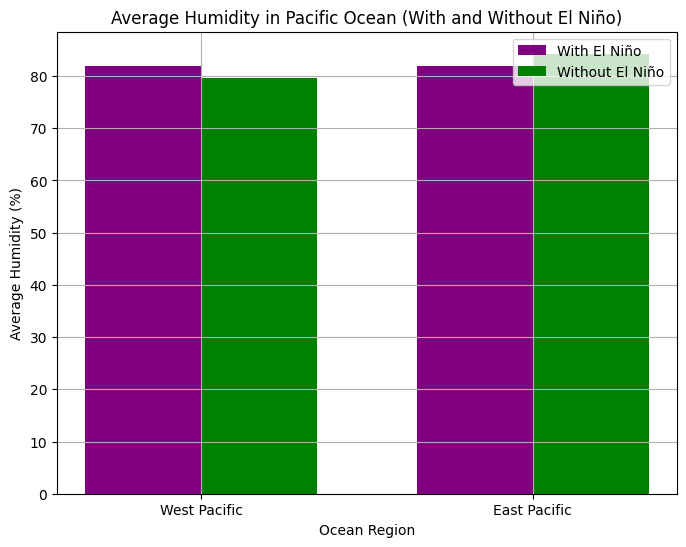

In [28]:
import matplotlib.pyplot as plt
import numpy as np

oceans = ['West Pacific', 'East Pacific']
humidity_with_elnino = [81.85, 81.97]
humidity_without_elnino = [79.60, 84.26]

x = np.arange(len(oceans))
width = 0.35

plt.figure(figsize=(8, 6))

plt.bar(x - width/2, humidity_with_elnino, width, label='With El Niño', color='purple')
plt.bar(x + width/2, humidity_without_elnino, width, label='Without El Niño', color='green')

plt.xlabel('Ocean Region')
plt.ylabel('Average Humidity (%)')
plt.title('Average Humidity in Pacific Ocean (With and Without El Niño)')
plt.xticks(x, oceans)
plt.legend()

plt.grid(True)
plt.show()


## **5. K-Mean Clustering**

In [29]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

cols = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 
        'air_temperature', 'sea_surface_temperature']
assembler = VectorAssembler(inputCols=cols, outputCol='features')
df_assembled = assembler.transform(df_clean)


K-means relies on Euclidean distance to measure the similarity between points. If the data have different ranges, the larger-scaled features will dominate the distance computation, which can bias the clustering results.

In [30]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

### **5.1. Finding Optimal K**

One of the challenge of kmeans clustering is defining the optimal number of clusters (K). The Elbow Method helps find the optimal number of clusters (K) by evaluating the WSSSE for different K values.

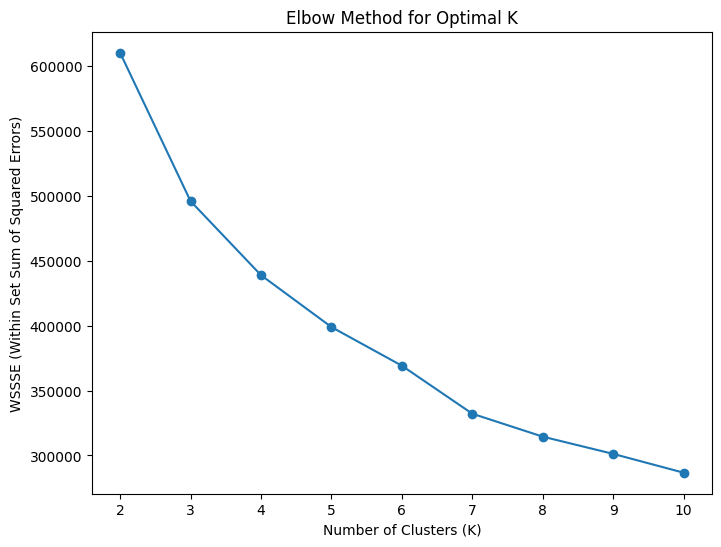

In [47]:
from pyspark.ml.clustering import KMeans

wssse_list = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures', predictionCol='cluster', k=k, seed=42)
    kmeans_model = kmeans.fit(df_scaled)
    wssse = kmeans_model.summary.trainingCost
    wssse_list.append(wssse)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wssse_list, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [66]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

additional_cols = ["zonal_winds", "meridional_winds", "longitude", "humidity"]
all_cols = ["air_temperature", "sea_surface_temperature"] + additional_cols

# Select features for clustering
westPacSouth = df_clean.filter((df_clean['Ocean'] == 'West Pacific') & (df_clean['Hemisphere'] == 'South')).select(*all_cols)
eastPacSouth = df_clean.filter((df_clean['Ocean'] == 'East Pacific') & (df_clean['Hemisphere'] == 'South')).select(*all_cols)

# Assemble features into a vector
assembler = VectorAssembler(inputCols=all_cols, outputCol="features")
westPacSouth = assembler.transform(westPacSouth)
eastPacSouth = assembler.transform(eastPacSouth)

# Scale features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
westPacSouth = scaler.fit(westPacSouth).transform(westPacSouth)
eastPacSouth = scaler.fit(eastPacSouth).transform(eastPacSouth)

In [67]:
# KMeans clustering
kmeans = KMeans(k=3, seed=1, featuresCol="scaledFeatures", predictionCol="Cluster")
westPacSouth = kmeans.fit(westPacSouth).transform(westPacSouth)
eastPacSouth = kmeans.fit(eastPacSouth).transform(eastPacSouth)

# Convert to Pandas
westPacSouth_pd = westPacSouth.select(*all_cols, "Cluster").toPandas()
eastPacSouth_pd = eastPacSouth.select(*all_cols, "Cluster").toPandas()

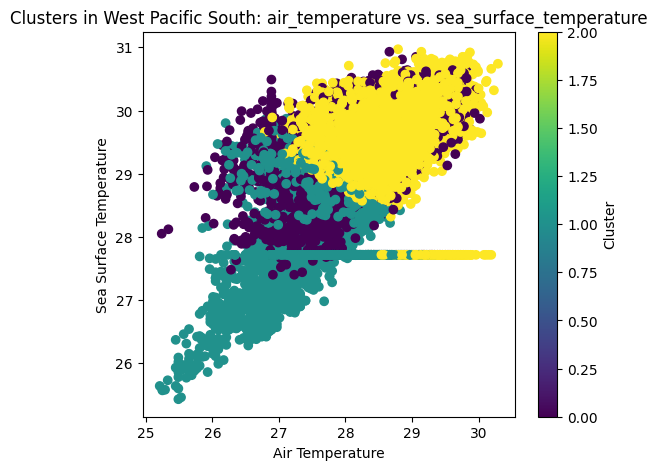

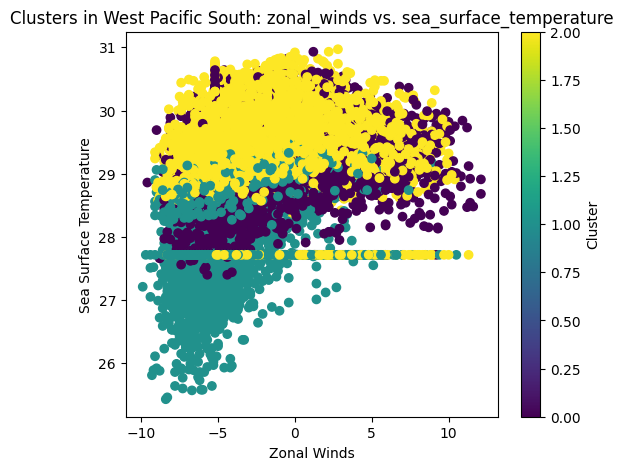

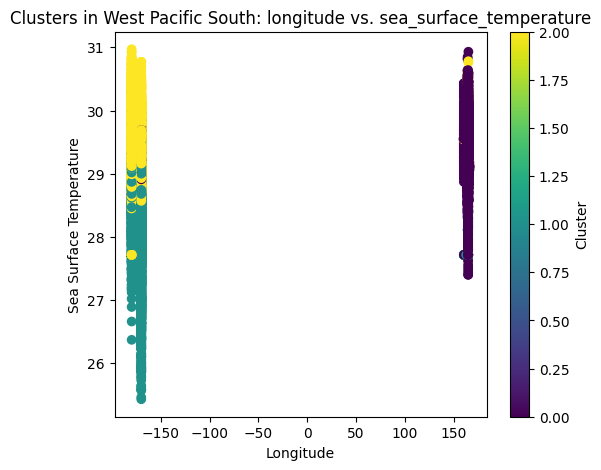

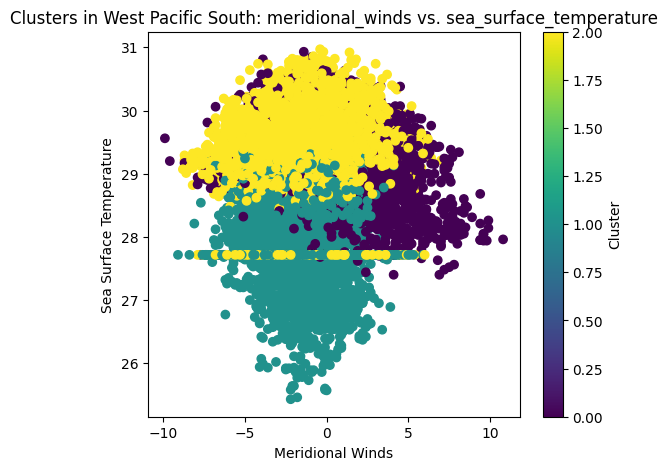

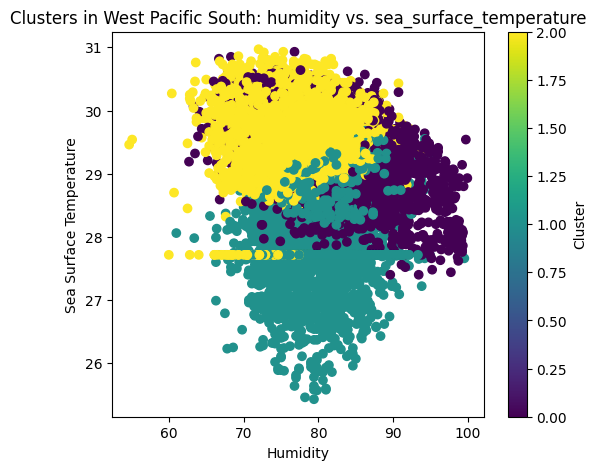

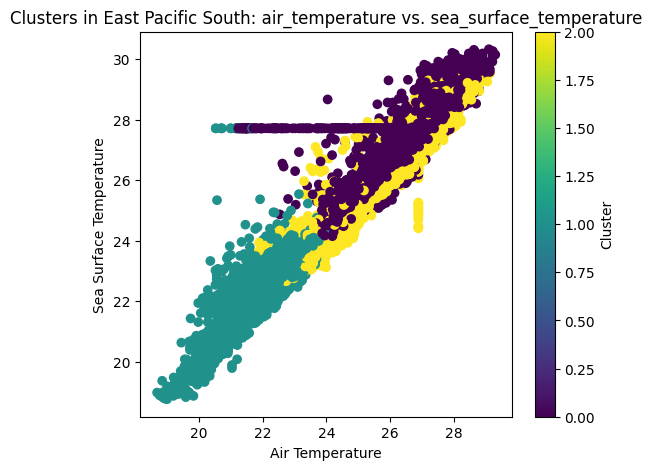

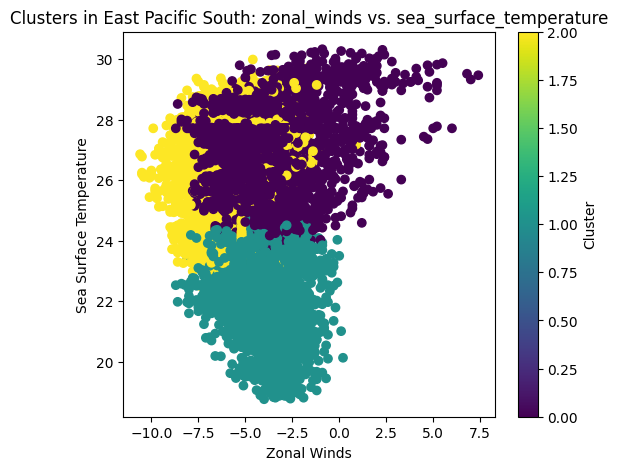

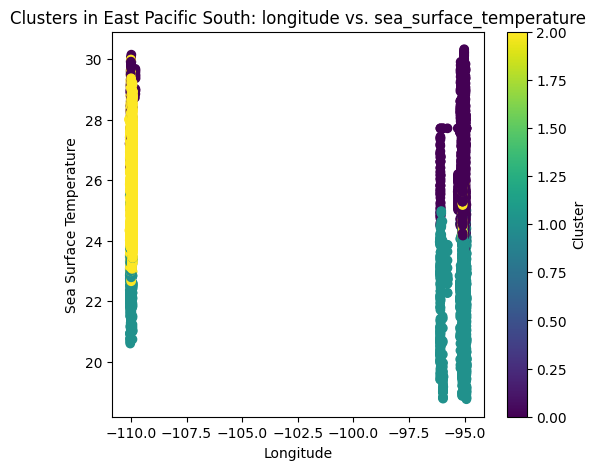

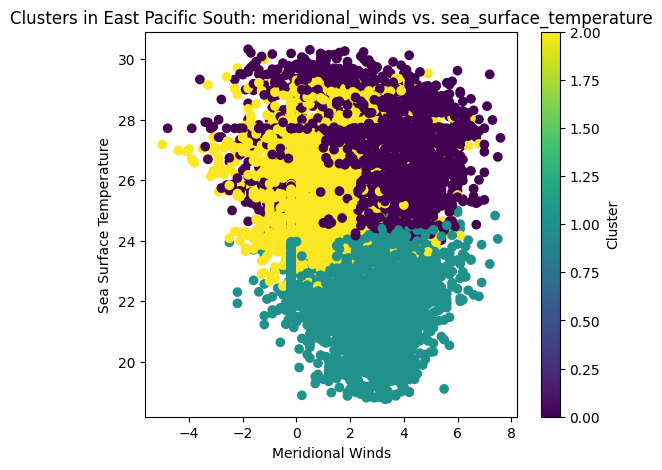

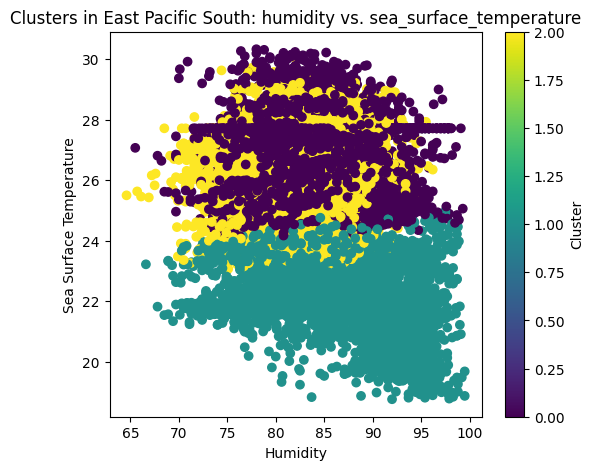

In [68]:
# Feature pairs to plot
feature_pairs = [
    ("air_temperature", "sea_surface_temperature"),
    ("zonal_winds", "sea_surface_temperature"),
    ("longitude", "sea_surface_temperature"),
    ("meridional_winds", "sea_surface_temperature"),
    ("humidity", "sea_surface_temperature")
]

# Plot function
def plot_clusters(df, ocean_name):
    for x_feature, y_feature in feature_pairs:
        plt.figure(figsize=(6, 5))
        plt.scatter(df[x_feature], df[y_feature], c=df['Cluster'], cmap='viridis')
        plt.title(f"Clusters in {ocean_name}: {x_feature} vs. {y_feature}")
        plt.xlabel(x_feature.replace("_", " ").title())
        plt.ylabel(y_feature.replace("_", " ").title())
        plt.colorbar(label="Cluster")
        plt.show()

# Generate plots for both regions
plot_clusters(westPacSouth_pd, "West Pacific South")
plot_clusters(eastPacSouth_pd, "East Pacific South")

In [69]:
print('West Pacific-specific Clusters')
westPacSouth.groupBy("Cluster").count().show()

print('East Pacific-specific Clusters')
eastPacSouth.groupBy("Cluster").count().show()

West Pacific-specific Clusters
+-------+-----+
|Cluster|count|
+-------+-----+
|      2| 6732|
|      0| 5481|
|      1| 4251|
+-------+-----+

East Pacific-specific Clusters
+-------+-----+
|Cluster|count|
+-------+-----+
|      2| 5511|
|      0| 2854|
|      1| 2888|
+-------+-----+



From the clustering task above, we can notice that:
1. Features like winds and air temperature shows clearer clusters on East Pacific Region
2. Features like humidty shows clearer clusters on West Pacific Region

Overall, we can not say that this clustering task performs well. We will use another techniques: PCA + Kmeans Clustering.

### **5.2. PCA + K-means Clustering**

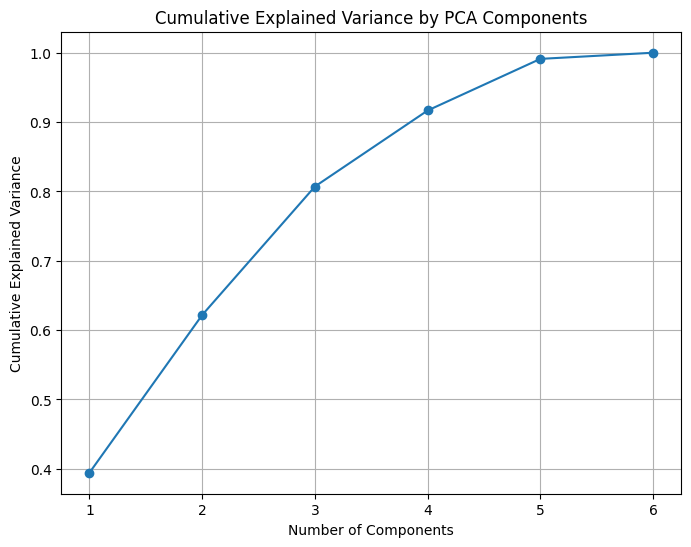

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

additional_cols = ["zonal_winds", "meridional_winds", "longitude", "humidity"]
all_cols = ["air_temperature", "sea_surface_temperature"] + additional_cols

eastPacSouth = df_clean[(df_clean['Ocean'] == 'East Pacific') & (df_clean['Hemisphere'] == 'South')][all_cols]

# Convert to Pandas DataFrame
eastPacSouth = eastPacSouth.toPandas()

eastPacSouth = eastPacSouth.apply(pd.to_numeric, errors='coerce').dropna()
scaler = StandardScaler()
eastPacSouth_scaled = scaler.fit_transform(eastPacSouth)

pca = PCA(n_components=6)
eastPacSouth_pca = pca.fit_transform(eastPacSouth_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()


As rule of thumb which preserve the 80%, we will choose number of components 3.

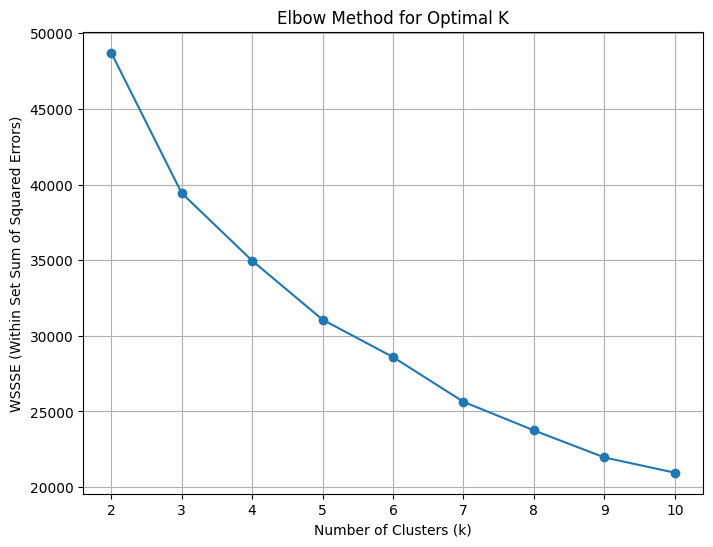

In [105]:
# Elbow method to find the optimal k (number of clusters)
wssse_list = []
for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans_model = kmeans.fit(eastPacSouth_pca)
    wssse = kmeans_model.inertia_
    wssse_list.append(wssse)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wssse_list, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


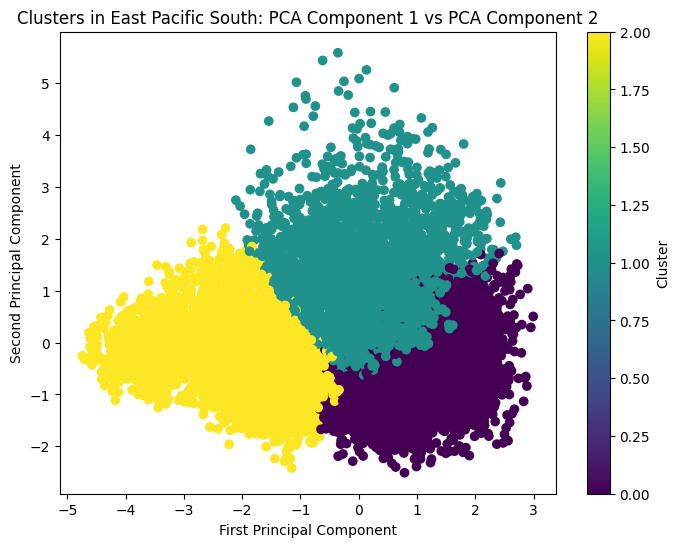

In [106]:
kmeans = KMeans(n_clusters=3, random_state=1)
eastPacSouth_clustered = pd.DataFrame(eastPacSouth_pca, columns=[f'PCA_{i+1}' for i in range(6)])
eastPacSouth_clustered['Cluster'] = kmeans.fit_predict(eastPacSouth_pca)

plt.figure(figsize=(8, 6))
plt.scatter(eastPacSouth_clustered['PCA_1'], eastPacSouth_clustered['PCA_2'], c=eastPacSouth_clustered['Cluster'], cmap='viridis')
plt.title('Clusters in East Pacific South: PCA Component 1 vs PCA Component 2')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster')
plt.show()

In [108]:
eastPacSouth_clustered

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,Cluster
0,1.070251,1.174929,-0.499982,-0.289609,-1.373350,0.088023,1
1,1.150108,0.853172,-0.864760,0.118956,-0.695793,0.170664,0
2,1.064986,0.818959,-0.490686,0.466114,-0.691048,0.219083,0
3,0.877695,1.089315,-1.069247,0.412525,-0.732231,0.218589,0
4,1.045185,0.717737,-0.727375,0.840857,-0.287044,0.217989,0
...,...,...,...,...,...,...,...
11248,0.855579,0.495089,1.909592,-0.506499,0.774273,-0.046611,1
11249,0.778311,0.586305,2.094552,-0.063377,0.850741,0.074269,1
11250,0.178317,0.870913,1.766615,0.432071,0.790001,-0.110670,1
11251,0.182002,0.997058,2.596122,-0.002231,0.030302,-0.005775,1


## **6. Regression**

### **6.1. Data Separation - Training and Testing**

In [67]:
from pyspark.ml.feature import VectorAssembler

features_columns = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature']
target = "sea_surface_temperature"

# Create a VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=features_columns, outputCol='features')
df_assembled = assembler.transform(df_clean)

train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)


In [50]:
train_count = train_data.count()
test_count = test_data.count()

print(f"Number of rows in the training set: {train_count}")
print(f"Number of rows in the test set: {test_count}")

Number of rows in the training set: 78650
Number of rows in the test set: 33669


### **6.2. Linear Regression**

In [51]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol='features', labelCol=target, regParam=0.1)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression R^2: {r2}")

Linear Regression RMSE: 0.6997383861495942
Linear Regression R^2: 0.8459116065150543


In [125]:
# Initialize evaluators for MSE, MAE, and R²
mse_evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

# Calculate the metrics
lr_mse = mse_evaluator.evaluate(predictions)
lr_mae = mae_evaluator.evaluate(predictions)
lr_r2 = r2_evaluator.evaluate(predictions)

# Display the results
print(f"Linear Regression MSE: {round(lr_mse,2)}")
print(f"Linear Regression MAE: {round(lr_mae,2)}")
print(f"Linear Regression R²: {round(lr_r2,2)}")

Linear Regression MSE: 0.49
Linear Regression MAE: 0.5
Linear Regression R²: 0.85


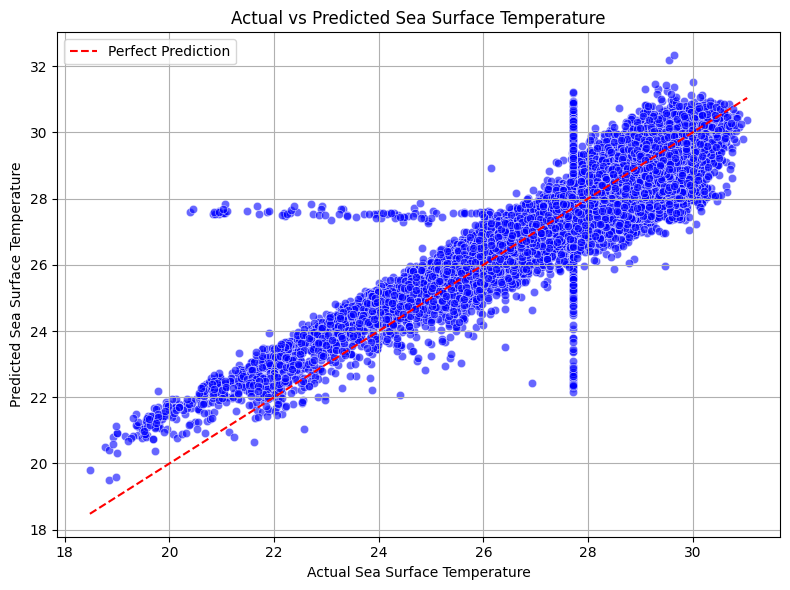

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

y_actual = predictions.select(target).toPandas()
y_pred = predictions.select("prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_actual[target], y=y_pred['prediction'], color='blue', alpha=0.6)
plt.title('Actual vs Predicted Sea Surface Temperature')
plt.xlabel('Actual Sea Surface Temperature')
plt.ylabel('Predicted Sea Surface Temperature')

plt.plot([y_actual[target].min(), y_actual[target].max()], 
         [y_actual[target].min(), y_actual[target].max()], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### **6.3. Decision Tree**

In [61]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='features', labelCol=target)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_rmse = evaluator.evaluate(dt_predictions)
dt_r2 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "r2"})

print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Decision Tree R^2: {dt_r2}")


Decision Tree RMSE: 0.6711925691546683
Decision Tree R^2: 0.8582272352781426


In [127]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluator for RMSE, MAE, and R²
rmse_evaluator = RegressionEvaluator(labelCol=target, metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol=target, metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol=target, metricName="r2")

# Calculate the metrics
rf_rmse = rmse_evaluator.evaluate(dt_predictions)
rf_mae = mae_evaluator.evaluate(dt_predictions)
rf_r2 = r2_evaluator.evaluate(dt_predictions)

rf_me = dt_predictions.withColumn("error", dt_predictions["prediction"] - dt_predictions[target]) \
                      .agg({"error": "avg"}).collect()[0][0]

# Display the results
print(f"Decision Tree MSE: {round(rf_rmse,2)}")
print(f"Decision Tree MAE: {round(rf_mae,2)}")
print(f"Decision Tree R²: {round(rf_r2,2)}")

Decision Tree MSE: 0.31
Decision Tree MAE: 0.39
Decision Tree R²: 0.9


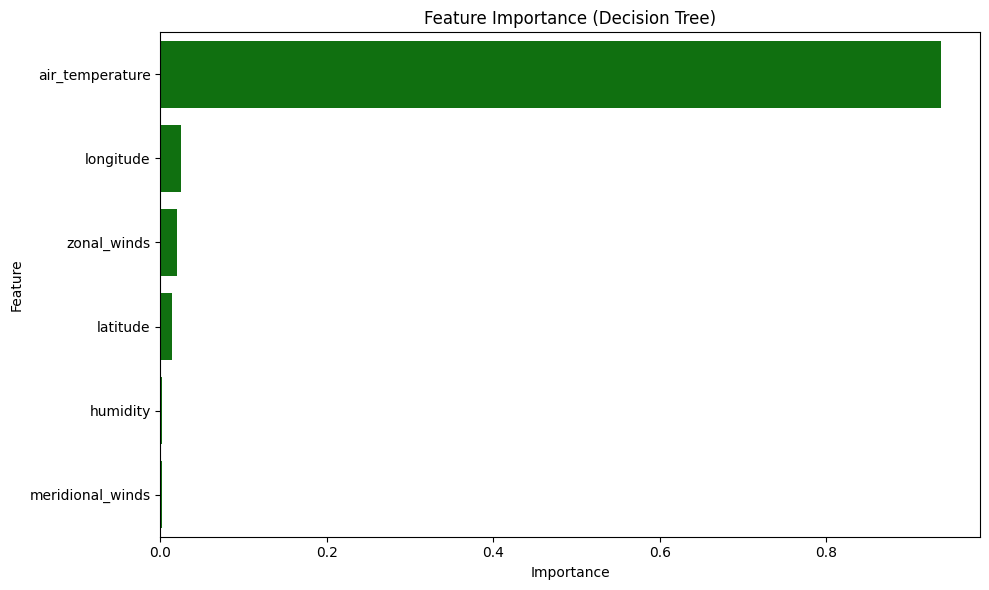

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = dt_model.featureImportances.toArray() 
assert len(features_columns) == len(feature_importances), "Number of features does not match the number of feature importances."

importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='green')
plt.title('Feature Importance (Decision Tree)')
plt.tight_layout()
plt.show()

### **6.4. Random Forest Regression**

In [41]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol=target)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R^2: {rf_r2}")

Random Forest RMSE: 0.7183029544775157
Random Forest R^2: 0.8376269925490906


In [128]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluator for RMSE, MAE, and R²
rmse_evaluator = RegressionEvaluator(labelCol=target, metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol=target, metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol=target, metricName="r2")

# Calculate the metrics
rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)

rf_me = rf_predictions.withColumn("error", rf_predictions["prediction"] - rf_predictions[target]) \
                      .agg({"error": "avg"}).collect()[0][0]

# Display the results
print(f"Random Forest MSE: {round(rf_rmse,2)}")
print(f"Random Forest MAE: {round(rf_mae,2)}")
print(f"Random Forest R²: {round(rf_r2,2)}")

Random Forest MSE: 0.29
Random Forest MAE: 0.39
Random Forest R²: 0.91


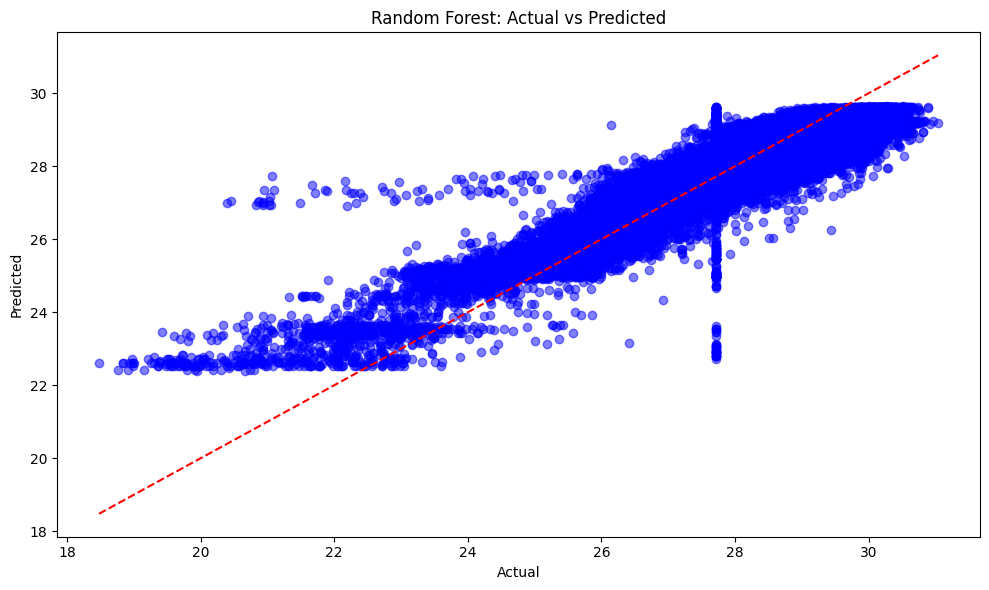

In [45]:
predictions_data = rf_predictions.select('prediction', target).toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_data[target], predictions_data['prediction'], color='blue', alpha=0.5)
plt.plot([min(predictions_data[target]), max(predictions_data[target])], 
         [min(predictions_data[target]), max(predictions_data[target])], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()


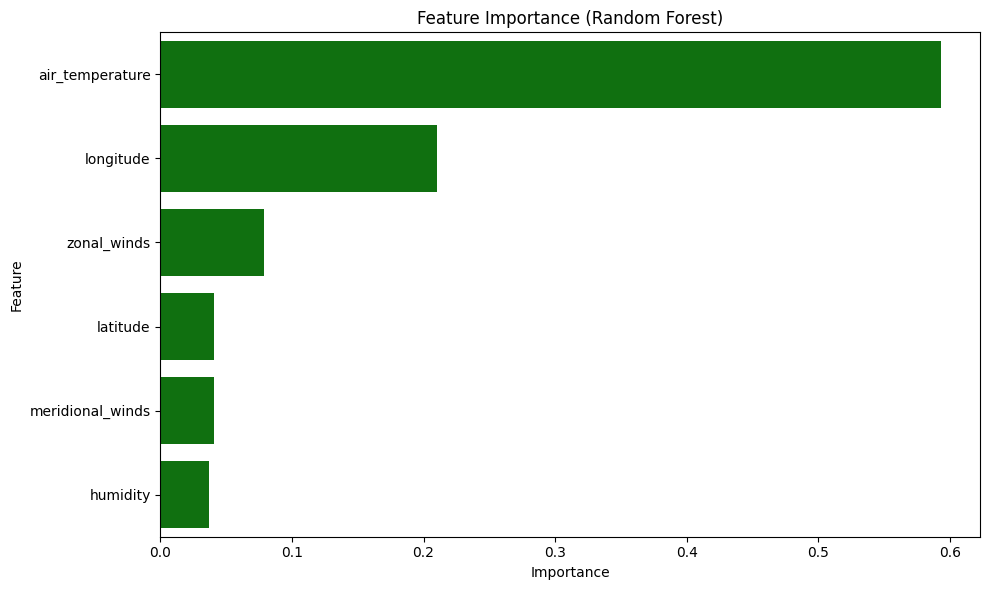

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = rf_model.featureImportances.toArray()
assert len(features_columns) == len(feature_importances), "Number of features does not match the number of feature importances."

importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='green')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [46]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import round

schema = StructType([
    StructField("Model", StringType(), True),
    StructField("RMSE", DoubleType(), True)
])

data = [
    ("Linear Regression", rmse),
    ("Decision Tree", dt_rmse),
    ("Random Forest", rf_rmse)
]

results_df = spark.createDataFrame(data, schema=schema)
results_df = results_df.withColumn("RMSE", round(results_df["RMSE"], 2))

results_df.show()


+-----------------+----+
|            Model|RMSE|
+-----------------+----+
|Linear Regression| 0.7|
|    Decision Tree|0.67|
|    Random Forest|0.72|
+-----------------+----+



### **Perform with Hyperparameter Tuning**

### **6.5. Linear Regression - Hyperparameter Tuning**

In [130]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                             estimatorParamMaps=lr_paramGrid,
                             evaluator=evaluator,
                             numFolds=3)

lr_cvModel = lr_crossval.fit(train_data)

lr_predictions = lr_cvModel.transform(test_data)

lr_mse = evaluator.evaluate(lr_predictions)
print(f"Best Linear Regression MSE: {lr_mse}")


Best Linear Regression MSE: 0.4833751409058783


In [131]:
best_lr_model = lr_cvModel.bestModel

best_regParam = best_lr_model._java_obj.getRegParam()
best_elasticNetParam = best_lr_model._java_obj.getElasticNetParam()

print(f"Best regParam: {best_regParam}")
print(f"Best elasticNetParam: {best_elasticNetParam}")

Best regParam: 0.01
Best elasticNetParam: 0.0


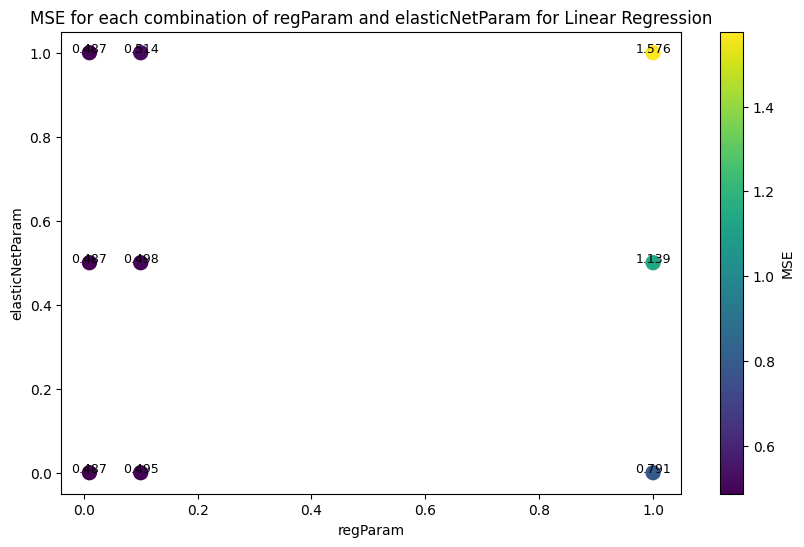

In [132]:
import matplotlib.pyplot as plt
import numpy as np

mse_results = []
for param_map, cv_metrics in zip(lr_cvModel.getEstimatorParamMaps(), lr_cvModel.avgMetrics):
    reg_param = param_map[lr.regParam]
    elastic_net_param = param_map[lr.elasticNetParam]
    mse_results.append((reg_param, elastic_net_param, cv_metrics)) 

mse_results = np.array(mse_results)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(mse_results[:, 0], mse_results[:, 1], c=mse_results[:, 2], cmap='viridis', s=100)

plt.xlabel('regParam')
plt.ylabel('elasticNetParam')
plt.title('MSE for each combination of regParam and elasticNetParam for Linear Regression')

plt.colorbar(scatter, label='MSE')

for i in range(len(mse_results)):
    plt.text(mse_results[i, 0], mse_results[i, 1], f'{mse_results[i, 2]:.3f}', fontsize=9, ha='center')

plt.show()


/var/folders/c6/1mv23h9s5rz3mp69yl624m340000gn/T/ipykernel_10686/59305676.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


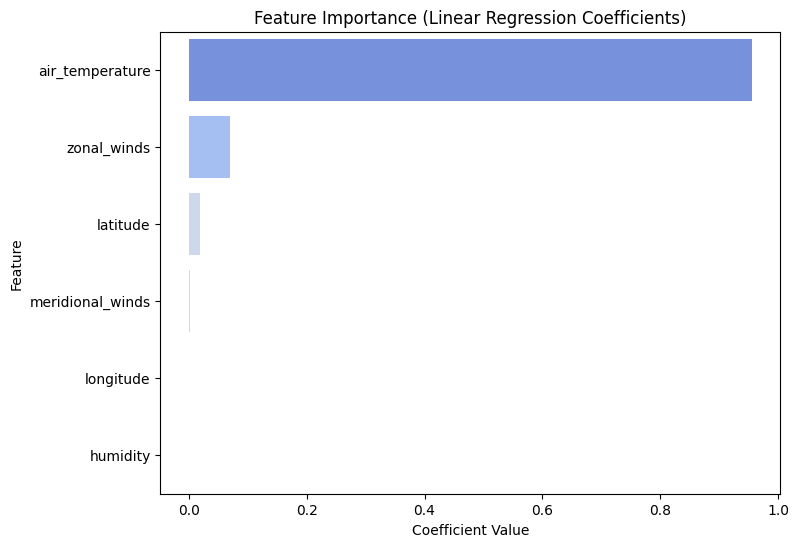

In [89]:
# Extract feature coefficients
feature_importances = best_lr_model.coefficients.toArray()

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.show()

### **6.6. Decision Tree - Hyperparameter Tuning**

In [133]:
dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.maxBins, [16, 32, 64]) \
    .build()

dt_crossval = CrossValidator(estimator=dt,
                             estimatorParamMaps=dt_paramGrid,
                             evaluator=evaluator,
                             numFolds=3)

dt_cvModel = dt_crossval.fit(train_data)

dt_predictions = dt_cvModel.transform(test_data)
dt_mse = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Regression MSE: {dt_mse}")

Decision Tree Regression MSE: 0.30639328293447293


In [134]:
best_dt_model = dt_cvModel.bestModel

best_maxDepth = best_dt_model._java_obj.getMaxDepth()
best_maxBins = best_dt_model._java_obj.getMaxBins()

print(f"Best maxDepth: {best_maxDepth}")
print(f"Best maxBins: {best_maxBins}")

Best maxDepth: 10
Best maxBins: 32


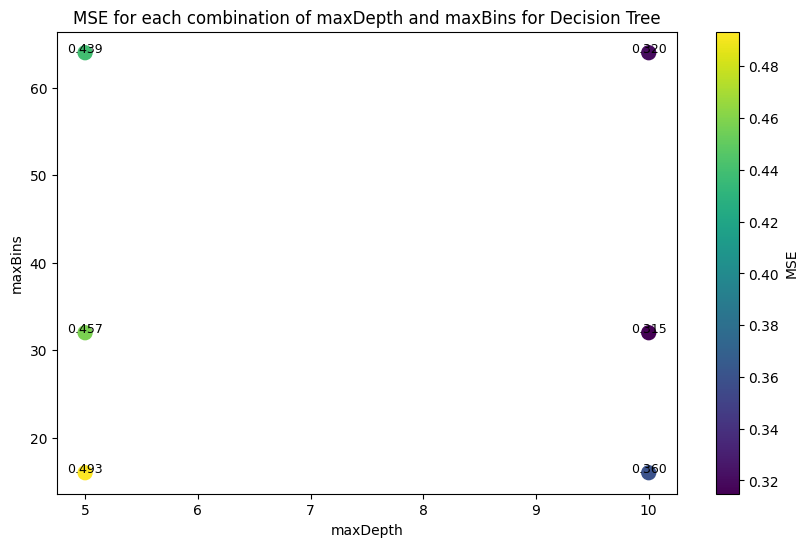

In [135]:
dt_mse_results = []
for param_map, cv_metrics in zip(dt_cvModel.getEstimatorParamMaps(), dt_cvModel.avgMetrics):
    max_depth = param_map[dt.maxDepth]
    max_bins = param_map[dt.maxBins]
    dt_mse_results.append((max_depth, max_bins, cv_metrics))

dt_mse_results = np.array(dt_mse_results)

plt.figure(figsize=(10, 6))

scatter = plt.scatter(dt_mse_results[:, 0], dt_mse_results[:, 1], c=dt_mse_results[:, 2], cmap='viridis', s=100)

plt.xlabel('maxDepth')
plt.ylabel('maxBins')
plt.title('MSE for each combination of maxDepth and maxBins for Decision Tree')

plt.colorbar(scatter, label='MSE')

for i in range(len(dt_mse_results)):
    plt.text(dt_mse_results[i, 0], dt_mse_results[i, 1], f'{dt_mse_results[i, 2]:.3f}', fontsize=9, ha='center')

plt.show()

/var/folders/c6/1mv23h9s5rz3mp69yl624m340000gn/T/ipykernel_10686/1846479998.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


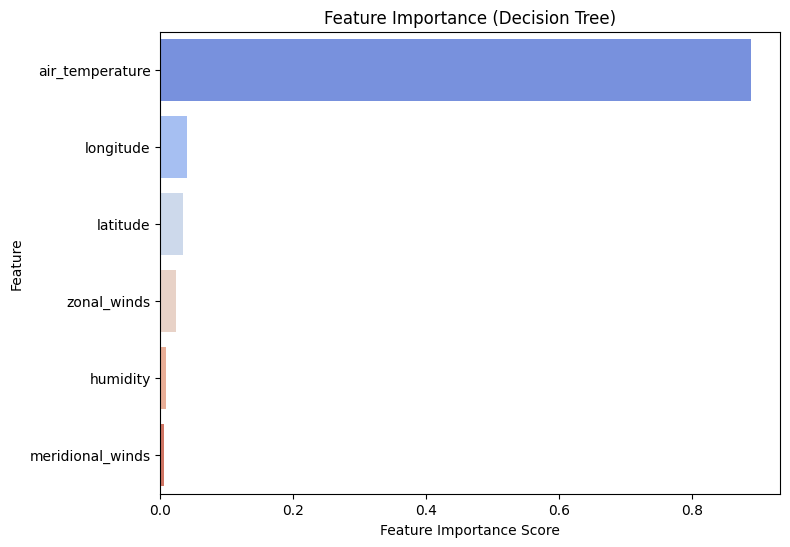

In [91]:
# Get the best Decision Tree model from cross-validation
best_dt_model = dt_cvModel.bestModel

# Extract feature importances
feature_importances = best_dt_model.featureImportances.toArray()

importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Decision Tree)')
plt.show()


### **6.7. Random Forest - Hyperparameter Tuning**

In [137]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

features_columns = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature']
target = "sea_surface_temperature"

assembler = VectorAssembler(inputCols=features_columns, outputCol='features')

df_assembled = assembler.transform(df_clean)

train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
scaled_train_data = scaler_model.transform(train_data)
scaled_test_data = scaler_model.transform(test_data)

rf = RandomForestRegressor(featuresCol="scaled_features", labelCol=target)

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

rf_crossval = CrossValidator(estimator=rf,
                             estimatorParamMaps=rf_paramGrid,
                             evaluator=evaluator,
                             numFolds=3)

rf_cvModel = rf_crossval.fit(scaled_train_data)

rf_predictions = rf_cvModel.transform(scaled_test_data)
rf_mse = evaluator.evaluate(rf_predictions)

print(f"Random Forest Regression MSE: {rf_mse}")

25/02/04 12:10:56 WARN DAGScheduler: Broadcasting large task binary with size 1465.8 KiB
25/02/04 12:11:05 WARN DAGScheduler: Broadcasting large task binary with size 1573.9 KiB
25/02/04 12:11:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/02/04 12:11:19 WARN DAGScheduler: Broadcasting large task binary with size 1483.3 KiB
25/02/04 12:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1584.4 KiB
25/02/04 12:11:25 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/02/04 12:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1481.3 KiB
25/02/04 12:11:41 WARN DAGScheduler: Broadcasting large task binary with size 1575.5 KiB
25/02/04 12:11:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/02/04 12:11:51 WARN DAGScheduler: Broadcasting large task binary with size 1576.6 KiB
25/02/04 12:11:53 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


Random Forest Regression MSE: 0.29467447294059856


In [138]:
best_rf_model = rf_cvModel.bestModel
print(f"Best numTrees: {best_rf_model.getNumTrees}")
print(f"Best maxDepth: {best_rf_model.getMaxDepth()}")


Best numTrees: 20
Best maxDepth: 10


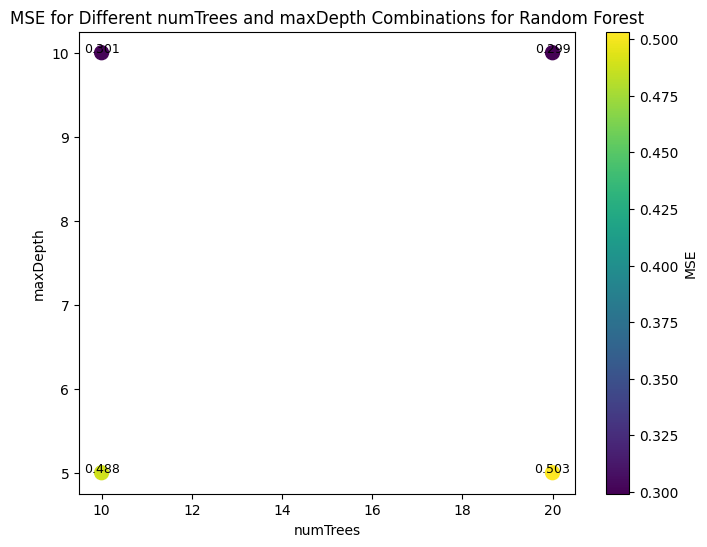

In [139]:
# Extract the results for each combination of numTrees and maxDepth
param_combinations = []
mse_values = []

for param_map, metric in zip(rf_cvModel.getEstimatorParamMaps(), rf_cvModel.avgMetrics):
    num_trees = param_map[rf.numTrees]
    max_depth = param_map[rf.maxDepth]
    param_combinations.append((num_trees, max_depth))
    mse_values.append(metric)

# Convert to numpy arrays for easy indexing
param_combinations = np.array(param_combinations)
mse_values = np.array(mse_values)

# Plot
fig = plt.figure(figsize=(8, 6))
sc = plt.scatter(param_combinations[:, 0], param_combinations[:, 1], c=mse_values, cmap='viridis', s=100)

plt.colorbar(sc, label='MSE')
plt.xlabel('numTrees')
plt.ylabel('maxDepth')
plt.title('MSE for Different numTrees and maxDepth Combinations for Random Forest')

# Add data labels for each point (the MSE values)
for i in range(len(param_combinations)):
    plt.text(param_combinations[i, 0], param_combinations[i, 1], f'{mse_values[i]:.3f}', fontsize=9, ha='center')

plt.show()

/var/folders/c6/1mv23h9s5rz3mp69yl624m340000gn/T/ipykernel_10686/942778123.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


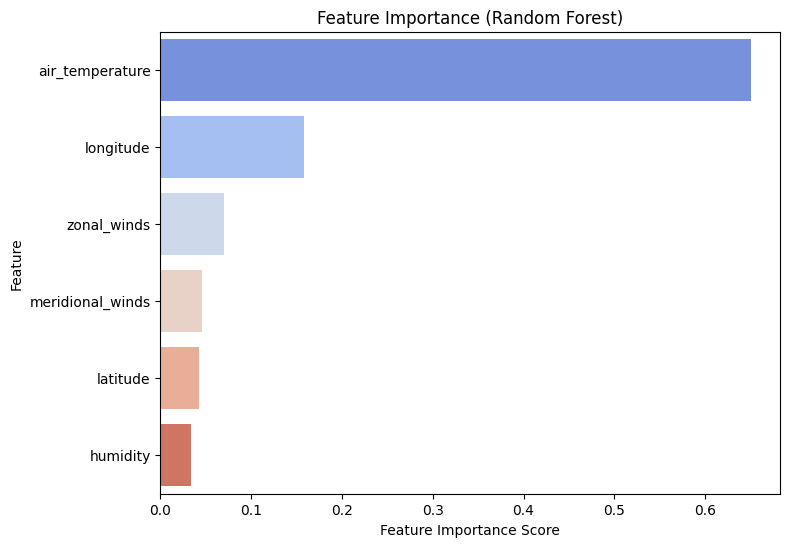

In [93]:
# Extract feature importances
feature_importances = best_rf_model.featureImportances.toArray()

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.show()


## **7. Conclusion**

### **7.1. Regression Performance Comparison**

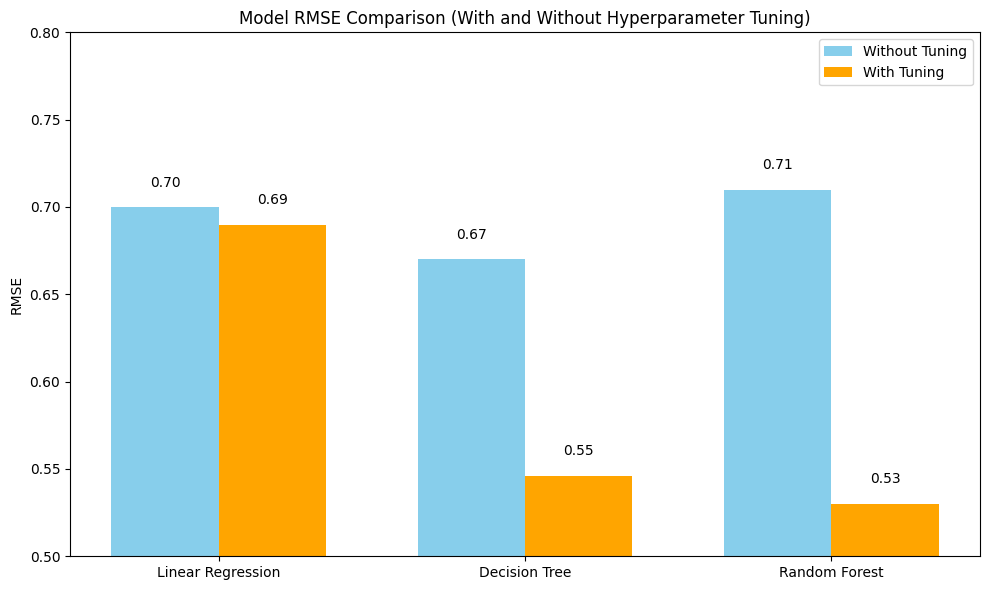

In [55]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Linear Regression', 'Decision Tree', 'Random Forest']
rmse_no_tuning = [0.7, 0.67, 0.71]
rmse_with_tuning = [0.6899, 0.5460, 0.53]  

x = np.arange(len(models))
plt.figure(figsize=(10, 6))
bar_width = 0.35

bars1 = plt.bar(x - bar_width / 2, rmse_no_tuning, width=bar_width, label='Without Tuning', color='skyblue')
bars2 = plt.bar(x + bar_width / 2, rmse_with_tuning, width=bar_width, label='With Tuning', color='orange')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom')

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom')

plt.xticks(x, models)
plt.ylabel('RMSE')
plt.title('Model RMSE Comparison (With and Without Hyperparameter Tuning)')
plt.legend()
plt.ylim(0.5, 0.8) 

plt.tight_layout()
plt.show()


### **7.2. Spark Configurations Used**

In [99]:
sc = spark.sparkContext
print(f"Master URL: {sc.master}")
print(f"Number of Executors: {sc.defaultParallelism}")  # Approximate number of workers
print(f"Total Cores: {sc._jsc.sc().getExecutorMemoryStatus().size()}")  # Total available cores


Master URL: spark://localhost:7077
Number of Executors: 2
Total Cores: 2


In [95]:
print(f"Driver Memory: {spark.conf.get('spark.driver.memory')}")
print(f"Executor Memory: {spark.conf.get('spark.executor.memory')}")


Driver Memory: 1g
Executor Memory: 1g


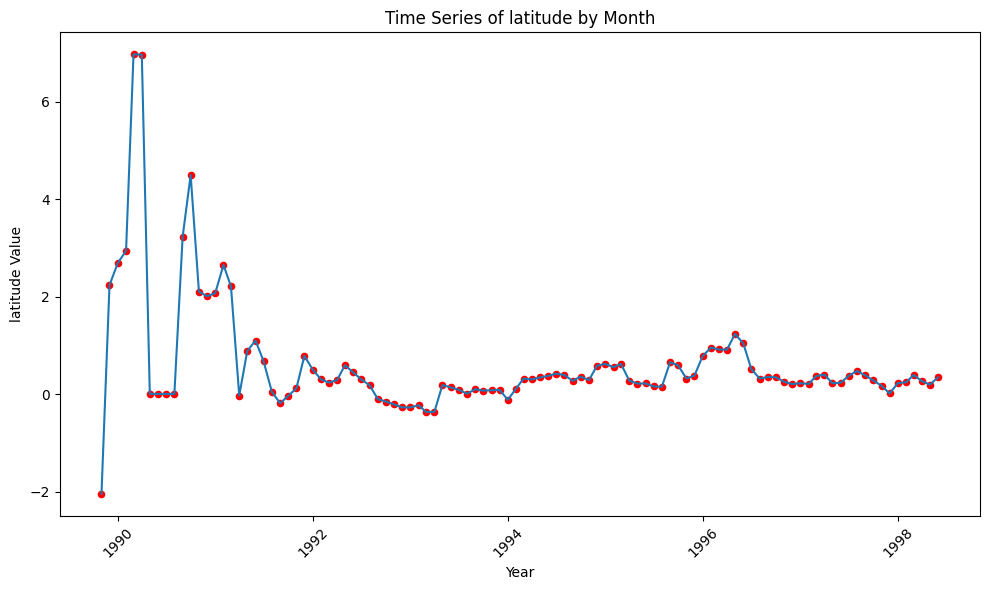

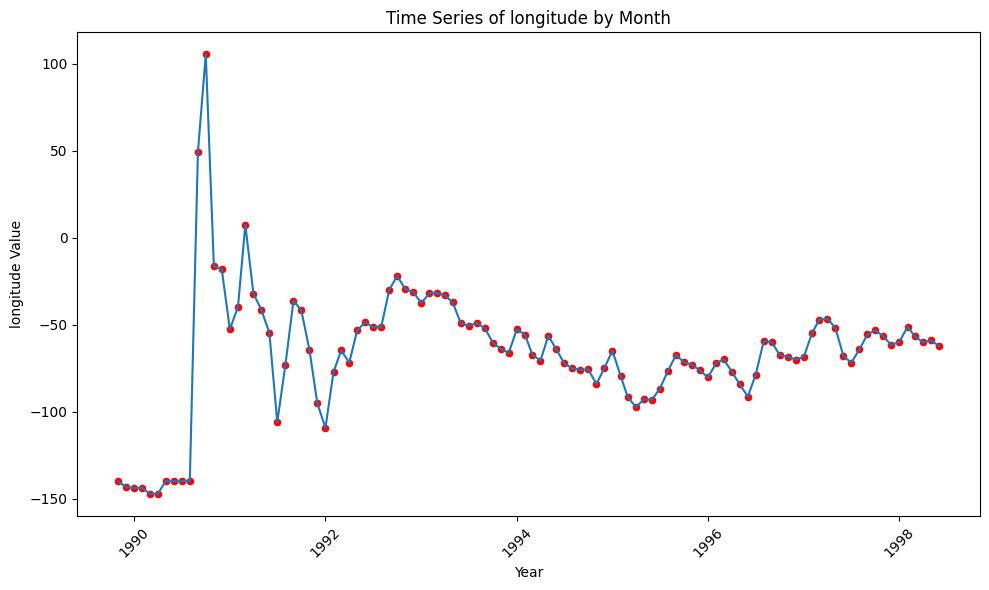

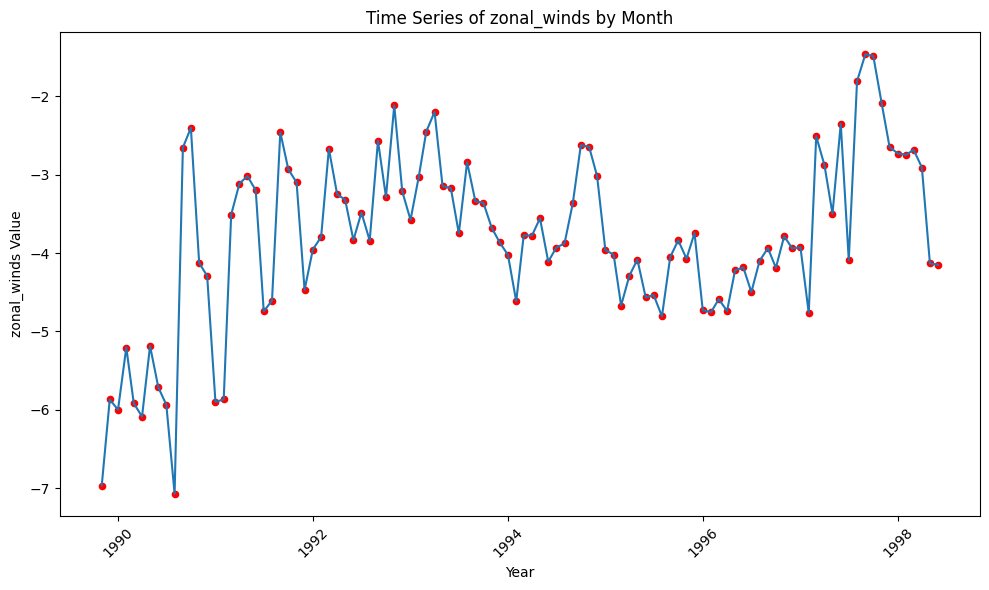

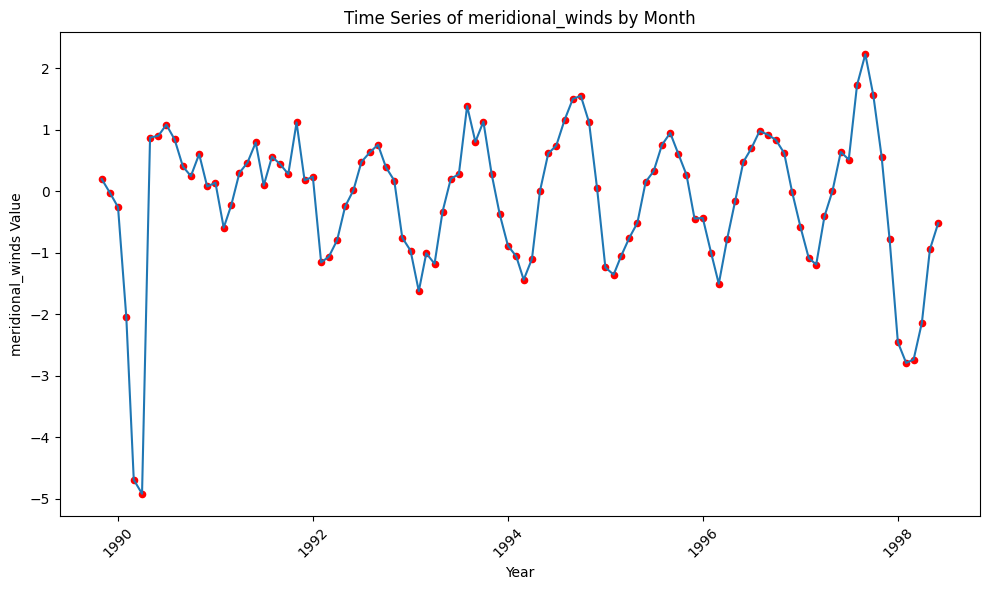

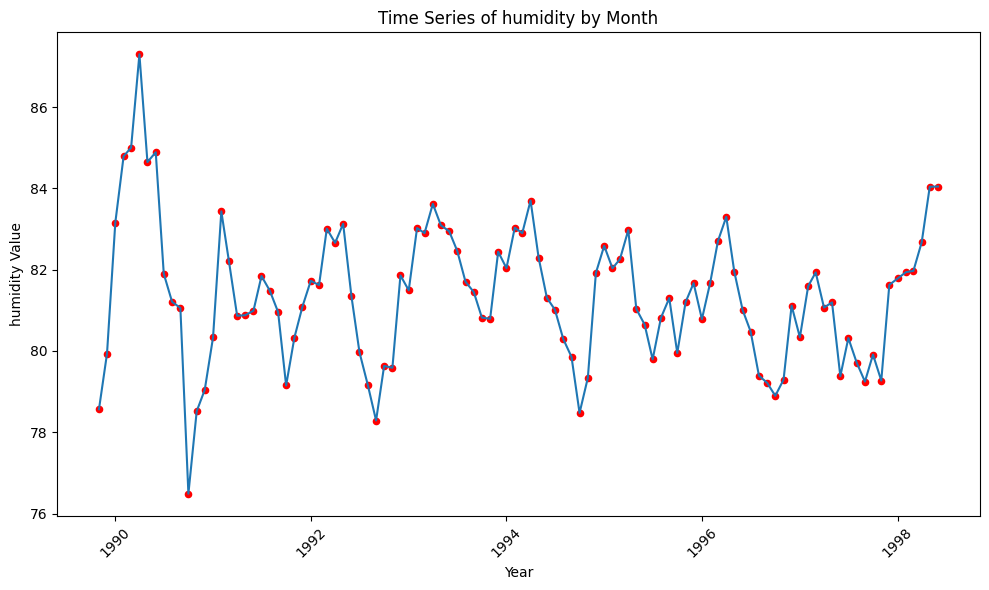

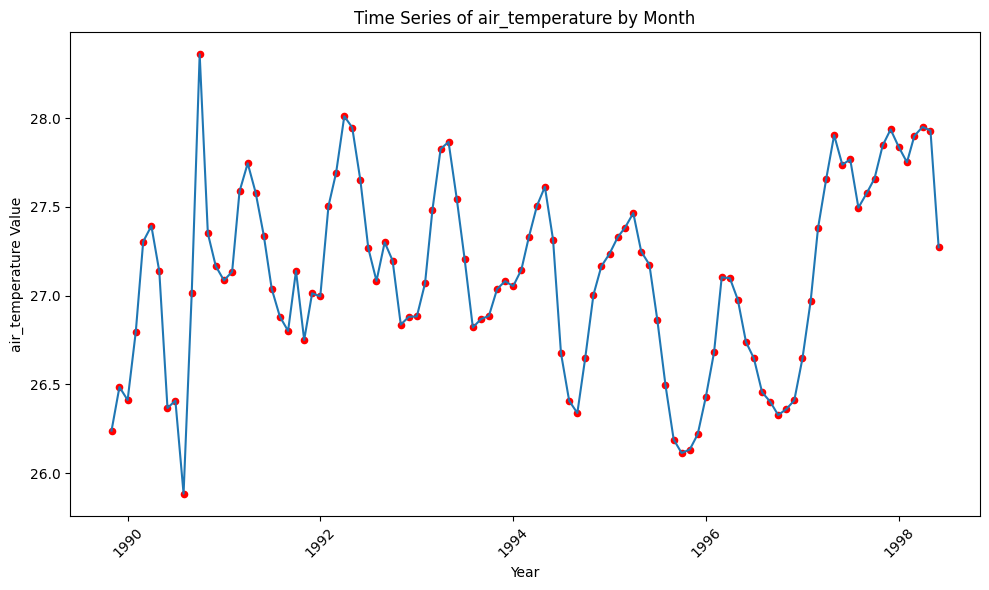

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df_clean.toPandas()

# Assuming 'date' is the column containing the date information
df_pandas['date'] = pd.to_datetime(df_pandas['date'])

# Extract year and month from the date
df_pandas['year_month'] = df_pandas['date'].dt.to_period('M')

# Convert 'year_month' to datetime for plotting
df_pandas['year_month_datetime'] = df_pandas['year_month'].dt.to_timestamp()

# Select the columns for plotting (assuming you have features like 'latitude', 'longitude', etc.)
features = ['latitude', 'longitude', 'zonal_winds', 'meridional_winds', 'humidity', 'air_temperature']

# Plot each feature individually
for feature in features:
    plt.figure(figsize=(10, 6))
    
    # Group by year and month and calculate the monthly average
    monthly_avg = df_pandas.groupby('year_month_datetime')[feature].mean()

    # Plot the time series for the feature
    plt.plot(monthly_avg.index, monthly_avg, label=feature, color='tab:blue')
    
    # Add data points to the plot
    plt.scatter(monthly_avg.index, monthly_avg, color='red', s=20)

    # Set x-axis labels to show only year (and smooth the ticks)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format to display the year
    
    # Title and labels
    plt.xlabel('Year')
    plt.ylabel(f'{feature} Value')
    plt.title(f'Time Series of {feature} by Month')
    
    plt.tight_layout()
    plt.show()
